## **Practice Imbalanced Classification**

## **Import libraries**

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('stroke.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## **Feature Information**

- id: unique identifier
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
-smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"
- stroke: 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [6]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [9]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in gender:  3
Unique values:  ['Male' 'Female' 'Other']

Total unique values in ever_married:  2
Unique values:  ['Yes' 'No']

Total unique values in work_type:  5
Unique values:  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Total unique values in Residence_type:  2
Unique values:  ['Urban' 'Rural']

Total unique values in smoking_status:  4
Unique values:  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']



In [10]:
for i in cat_features:
    print(df[i].value_counts())
    print()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Yes    3353
No     1757
Name: ever_married, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [11]:
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [12]:
# Drop 'other' in gender
df = df.drop(df.index[3116])
df = df.reset_index()
df

,index,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5105,5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5106,5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5107,5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [13]:
df = df.drop(['index'], axis=1)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5105,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5106,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5107,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [14]:
df.corr()['stroke']

id                   0.006430
age                  0.245239
hypertension         0.127891
heart_disease        0.134905
avg_glucose_level    0.131991
bmi                  0.042341
stroke               1.000000
Name: stroke, dtype: float64

In [15]:
filtering = df.filter(['gender','heart_disease','hypertension'])
suffer_gender = filtering.groupby('gender').count().reset_index()
suffer_gender

,gender,heart_disease,hypertension
0,Female,2994,2994
1,Male,2115,2115


In [16]:
df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [17]:
df['stroke'].value_counts()/len(df['stroke'])*100

0    95.126248
1     4.873752
Name: stroke, dtype: float64

## **Imputing missing values**

In [18]:
imp_iter = IterativeImputer(max_iter=10, random_state=42)
df[['bmi']] = imp_iter.fit_transform(df[['bmi']])

In [19]:
df['bmi'].isna().sum()

0

In [20]:
df.drop(columns=['id'], inplace=True)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.89456,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,80.0,1,0,Yes,Private,Urban,83.75,28.89456,never smoked,0
5105,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.00000,never smoked,0
5106,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.60000,never smoked,0
5107,Male,51.0,0,0,Yes,Private,Rural,166.29,25.60000,formerly smoked,0


## **Pre-processing and Data Transform**

In [21]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'), ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
],  remainder='passthrough')

In [22]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot', OneHotEncoder(drop='first'),
                                 ['gender', 'ever_married', 'work_type',
                                  'Residence_type', 'smoking_status'])])

In [23]:
transformer.fit_transform(df)

array([[  1.       ,   1.       ,   0.       , ..., 228.69     ,
         36.6      ,   1.       ],
       [  0.       ,   1.       ,   0.       , ..., 202.21     ,
         28.8945599,   1.       ],
       [  1.       ,   1.       ,   0.       , ..., 105.92     ,
         32.5      ,   1.       ],
       ...,
       [  0.       ,   1.       ,   0.       , ...,  82.99     ,
         30.6      ,   0.       ],
       [  1.       ,   1.       ,   0.       , ..., 166.29     ,
         25.6      ,   0.       ],
       [  0.       ,   1.       ,   0.       , ...,  85.28     ,
         26.2      ,   0.       ]])

In [24]:
transformer.get_feature_names()

['one hot__x0_Male',
 'one hot__x1_Yes',
 'one hot__x2_Never_worked',
 'one hot__x2_Private',
 'one hot__x2_Self-employed',
 'one hot__x2_children',
 'one hot__x3_Urban',
 'one hot__x4_formerly smoked',
 'one hot__x4_never smoked',
 'one hot__x4_smokes',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke']

In [25]:
df_encoded = pd.DataFrame(transformer.fit_transform(df))
df_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,67.0,0.0,1.0,228.69,36.60000,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,61.0,0.0,0.0,202.21,28.89456,1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,1.0,105.92,32.50000,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,49.0,0.0,0.0,171.23,34.40000,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,79.0,1.0,0.0,174.12,24.00000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,80.0,1.0,0.0,83.75,28.89456,0.0
5105,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,81.0,0.0,0.0,125.20,40.00000,0.0
5106,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,35.0,0.0,0.0,82.99,30.60000,0.0
5107,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,51.0,0.0,0.0,166.29,25.60000,0.0


In [26]:
df_encoded.columns = transformer.get_feature_names()
df_encoded

,one hot__x0_Male,one hot__x1_Yes,one hot__x2_Never_worked,one hot__x2_Private,one hot__x2_Self-employed,one hot__x2_children,one hot__x3_Urban,one hot__x4_formerly smoked,one hot__x4_never smoked,one hot__x4_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,67.0,0.0,1.0,228.69,36.60000,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,61.0,0.0,0.0,202.21,28.89456,1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,1.0,105.92,32.50000,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,49.0,0.0,0.0,171.23,34.40000,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,79.0,1.0,0.0,174.12,24.00000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,80.0,1.0,0.0,83.75,28.89456,0.0
5105,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,81.0,0.0,0.0,125.20,40.00000,0.0
5106,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,35.0,0.0,0.0,82.99,30.60000,0.0
5107,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,51.0,0.0,0.0,166.29,25.60000,0.0


## **Define X and y**

In [27]:
X = df.drop(columns=['stroke'], axis=1)
y = df['stroke']

In [28]:
y.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

## **Data Splitting**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify = y,
    test_size = 0.2,
    random_state = 42
)

In [30]:
X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.transform(X_test)

## **Scaling**

In [31]:
# Scaling
scaler = StandardScaler()

scaler.fit(X_train_prep)

X_train_prep_scaled = scaler.transform(X_train_prep)
X_test_prep_scaled = scaler.transform(X_test_prep)

## **Imbalance Data Treatment**

In [32]:
# Define models
knn = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
logreg = LogisticRegression(solver='liblinear', random_state=42)

# Define imbalance treatment methods
models = [knn, tree, logreg]
score = []
nilai_mean = []
nilai_std = []

for i in models:
    smote = SMOTE(random_state=42)
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('balancing', smote),
        ('model', i)
    ])

    model_cv = cross_val_score(estimator, X_train_prep_scaled, y_train, cv=skfold, scoring='f1', error_score='raise')
    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [33]:
pd.DataFrame({
    'model':['knn', 'tree', 'logreg'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,knn,0.132846,0.027221
1,tree,0.196851,0.017884
2,logreg,0.230956,0.016509


## **Tuning the model benchmark**

In [34]:
# Create the algorithm chains
smote = SMOTE()
model = LogisticRegression()
estimator = Pipeline([('balancing', smote), ('clf', model)])

# Hyperparameter space
hyperparam_space = {
    'clf__C':[100, 10, 1, 0.1, 0.01, 0.001],
    'clf__solver':['liblinear','newton-cg']
}

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Hyperparameter tuning
grid_search = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'f1', # metrics
    n_jobs = -1 # use all cores
)

In [37]:
grid_search.fit(X_train_prep_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('balancing', SMOTE()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'clf__solver': ['liblinear', 'newton-cg']},
             scoring='f1')

In [38]:
print('Best score:', grid_search.best_score_)
print('Best params:', grid_search.best_params_)

Best score: 0.23166535372075114
Best params: {'clf__C': 100, 'clf__solver': 'newton-cg'}


In [39]:
# Create the algorithm chains
smote = SMOTE()
model = KNeighborsClassifier()
estimator = Pipeline([('balancing', smote), ('model', model)])

# Hyperparameter space
hyperparam_space = {
    'model__n_neighbors':[3, 5, 7, 9, 11, 13],
    'model__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Hyperparameter tuning
grid_search_knn = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'f1', # metrics
    n_jobs = -1 # use all cores
)

In [40]:
grid_search_knn.fit(X_train_prep_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('balancing', SMOTE()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                              'brute'],
                         'model__n_neighbors': [3, 5, 7, 9, 11, 13]},
             scoring='f1')

In [41]:
print('Best score:', grid_search_knn.best_score_)
print('Best params:', grid_search_knn.best_params_)

Best score: 0.1644821008560211
Best params: {'model__algorithm': 'auto', 'model__n_neighbors': 13}


## **Before & after tuning**

### **Before**

In [42]:
smote = SMOTE()
model =  LogisticRegression()

estimator = Pipeline([('balancing',smote), ('clf',model)])

estimator.fit(X_train_prep_scaled,y_train)
y_pred = estimator.predict(X_test_prep_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.74      0.84       972
           1       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.81      1022



### **After**

In [43]:
grid_search.best_estimator_.fit(X_train_prep_scaled, y_train)
y_pred_tuning = grid_search.best_estimator_.predict(X_test_prep_scaled)

In [44]:
print(classification_report(y_test, y_pred_tuning))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.82      1022



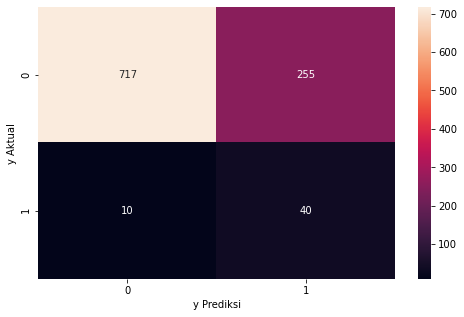

In [45]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

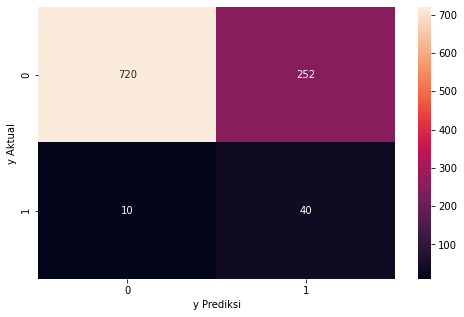

In [46]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

## **Interpretation**

TP: The model predicts people will have a stroke and actually it does (40).<br>
FP: The model predicts people will have a stroke, but they don't (258).
<br><br>
TN: The model predicts people don't have a stroke and actually doesn't (714).<br>
FN: The model predicts that people do not have a stroke, but actually have a stroke (10).
<br><br>
In this case, FP and FN are both important because false positives can result in the person taking treatment that is not really needed and false negatives can lead to errors in diagnosis, which is a serious matter because the stroke is not treated properly as soon as possible.

There is no significant difference between the results before and after tuning. Because the number of samples of the negative class is much more than the positive class, from the confusion matrix plot it can be seen that there are many samples of the negative class that can become false positives. On the other hand, because there are only a small number of positive class samples, there are also a few positive class samples that become false negatives.